## Natural Language Processing with Disaster Tweets
##### Authors: Ruth Ashford, Toby Petty and Li Jin
This report is based on a Kaggle competition: https://www.kaggle.com/c/nlp-getting-started/data

The aim is to classify tweets as being about a disaster or not. We are given a labelled training data set a long with a unlabelled test data set. 

In the report, we perform initial EDA on the data, cleaning and processing of the tweets text and evaluate the performance Naive Bayes, Neural Network and Logistic Regression models.

In [1]:
import numpy as np
import os
import pandas as pd


data_fp = os.path.join(os.getcwd(), "data")
train_fp = os.path.join(data_fp, "train.csv")
train_full = pd.read_csv(train_fp, encoding="utf-8")
test_fp = os.path.join(data_fp, "test.csv")
test = pd.read_csv(test_fp, encoding="utf-8")

print(f"Train: {train_full.shape}")
print(f"Test:  {test.shape}")

train_full.head()

Train: (7613, 5)
Test:  (3263, 4)


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


Kaggle supplies the test set (without target labels), so we will submit our final predictions there to get the ultimate measure of model performance. We separate 20% of the training data as a validation set.

## Exploratory data analysis


Firstly we will check the number of samples that are labelled as disaster (1) and non-disaster (0)

In [3]:
train_label_summary = train.groupby('target').agg(Total = ('id','count'))
train_label_summary['Percentage'] = round(train_label_summary['Total'] / train.shape[0] * 100, 1)
train_label_summary

,Total,Percentage
target,,
0,3473,57.0
1,2617,43.0


This shows us that we have a fairly even split of disaster and non-disaster labelled samples. This is useful when training our model but tell us that this data set is not likely to be representative of the general population of tweets, we know in general there are far less than 43% of tweets that are about disasters.

### Keywords
Next we want to take a look at the keywords and how they relate to the target. The majority of tweets in our training data have a keyword associated with them, there is just 0.2% of samples that don't.

In [7]:
keyword_label_summary = train.groupby('keyword').agg(percentage_disaster_occurance = ('target', 'mean')).reset_index()

keyword_disaster_count = train[train['target'] == 1].groupby('keyword').agg(disaster_count = ('target', 'count')).reset_index()
keyword_not_disaster_count = train[train['target'] == 0].groupby('keyword').agg(not_disaster_count = ('target', 'count')).reset_index()

keyword_label_summary = keyword_label_summary.merge(keyword_disaster_count, how='left')
keyword_label_summary = keyword_label_summary.merge(keyword_not_disaster_count, how='left')

print(f' Percentage of tweets without a keyword: {round(1 - train.keyword.isna().sum() / train.shape[0] * 100 , 2)}%')

 Percentage of tweets without a keyword: 0.2%


Below are the words that come up most often in disaster tweets.

In [5]:
keyword_label_summary.sort_values('percentage_disaster_occurance', 
                                  ascending=False).head(20)

,keyword,percentage_disaster_occurance,disaster_count,not_disaster_count
62,debris,1.000000,30.0,NaN
70,derailment,1.000000,33.0,NaN
219,wreckage,1.000000,25.0,NaN
153,outbreak,0.965517,28.0,1.0
152,oil%20spill,0.964286,27.0,1.0
205,typhoon,0.962963,26.0,1.0
187,suicide%20bombing,0.962963,26.0,1.0
186,suicide%20bomber,0.956522,22.0,1.0
32,bombing,0.950000,19.0,1.0
147,nuclear%20disaster,0.928571,26.0,2.0


Below are the kewords that come up most often in non-disaster tweets. I can see that 'body%20bags' and body%20bag' is a duplicate and needs cleaning up. There are a lot of words here that I would associate with disasters, such as 'ruin', 'explode' and 'wrecked' but these are also words that could be used in a sentence when not describing a disaster.

In [6]:
keyword_label_summary.sort_values('percentage_disaster_occurance', 
                                  ascending=True).head(20)

,keyword,percentage_disaster_occurance,disaster_count,not_disaster_count
21,blew%20up,0.000000,NaN,25.0
2,aftershock,0.000000,NaN,25.0
29,body%20bags,0.026316,1.0,37.0
19,blazing,0.033333,1.0,29.0
25,bloody,0.034483,1.0,28.0
170,ruin,0.035714,1.0,27.0
27,body%20bag,0.041667,1.0,23.0
201,traumatised,0.043478,1.0,22.0
48,collide,0.043478,1.0,22.0
88,electrocute,0.043478,1.0,22.0


### Length of tweets
We want to understand if the length of the tweet differs for disaster tweets versus non-disaster tweets

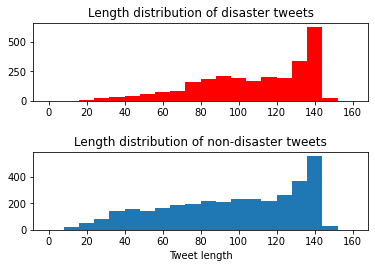

Average length of disaster tweets is 108 with standard deviation 29
Average length of non-disaster tweets is 96 with standard deviation 36


In [10]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2)
fig. tight_layout(pad=3.0)

disaster_length = train[train['target'] == 1]['text'].apply(lambda x: len(x))
non_disaster_length = train[train['target'] == 0]['text'].apply(lambda x: len(x))

axs[0].hist(x = disaster_length, color='red', bins=20, range = (0,160))
axs[0].set_title('Length distribution of disaster tweets')
axs[1].hist(x = non_disaster_length, bins=20, range = (0,160))
axs[1].set_title('Length distribution of non-disaster tweets')
axs[1].set_xlabel('Tweet length')

plt.show()

print(f'Average length of disaster tweets is {round(disaster_length.mean())} ' \
 f'with standard deviation {round(disaster_length.std())}')

print(f'Average length of non-disaster tweets is {round(non_disaster_length.mean())} ' \
 f'with standard deviation {round(non_disaster_length.std())}')


We can see that the do seem to be slightly longer, but not by a huge amount.

### Number of words
Similarily, we want to understand if there are any key differences in the number of words in the tweets.

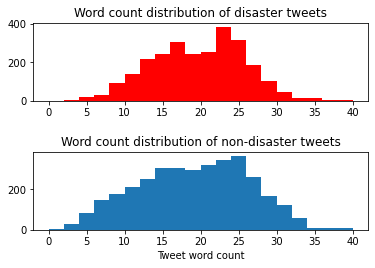

Average length of disaster tweets is 19 with standard deviation 6
Average length of non-disaster tweets is 19 with standard deviation 7


In [12]:
from nltk.tokenize import word_tokenize

fig, axs = plt.subplots(2)
fig. tight_layout(pad=3.0)

disaster_wc = train[train['target'] == 1]['text'].apply(lambda x: len(word_tokenize(x)))
non_disaster_wc = train[train['target'] == 0]['text'].apply(lambda x: len(word_tokenize(x)))

axs[0].hist(x = disaster_wc, color='red', bins=20, range = (0,40))
axs[0].set_title('Word count distribution of disaster tweets')
axs[1].hist(x = non_disaster_wc, bins=20, range = (0,40))
axs[1].set_title('Word count distribution of non-disaster tweets')
axs[1].set_xlabel('Tweet word count')

plt.show()

print(f'Average length of disaster tweets is {round(disaster_wc.mean())} ' \
 f'with standard deviation {round(disaster_wc.std())}')

print(f'Average length of non-disaster tweets is {round(non_disaster_wc.mean())} ' \
 f'with standard deviation {round(non_disaster_wc.std())}')

Again, no real difference here between disaster and non-disaster tweets.

### Location

Location data is provided for 65% of the samples. The location data seems to range from being as broad as a country, or as specific as the name of a restaurant.

In [34]:
print(f' Percentage of tweets without a location: ' + 
      f'{round((1 - train.location.isna().sum() / train.shape[0]) * 100 , 2)}%')

pd.DataFrame(train.location.unique())

 Percentage of tweets without a location: 66.55%


,0
0,NaN
1,UK
2,"Montgomery County, MD"
3,"Los Angeles, CA"
4,"Athens,Greece"
...,...
2751,"ÌÏT: 35.223347,-80.827834"
2752,ITALY
2753,Detroit Tigers Dugout
2754,Santiago de Cmpostela Galicia


### Baseline model

We use CountVectorizer and BernoulliNB to create a baseline model, and get benchmark score against the validation set.

Note that the target labels are binary outcomes, so they comrpise a Bernoulli distribution where  𝑝≈0.43 . Therefore accuracy is the chosen metric of performance, since there isn't a huge class imbalance.

### Training and validation data
We will reserve 20% of the training data set and a validation data set to test iterations of the model against.

In [36]:
# Shuffle the index in case there are patterns in the order of the training data:
np.random.seed(42)
shuffled_ix = list(train_full.index)
np.random.shuffle(shuffled_ix)
cutoff = int(len(shuffled_ix)*0.8)
train = train_full.loc[shuffled_ix[:cutoff]].copy()
validation = train_full.loc[shuffled_ix[cutoff:]].copy()

print(f'Train data set contains {train.shape[0]} samples')
print(f'Validation data set contains {validation.shape[0]} samples')

Train data set contains 6090 samples
Validation data set contains 1523 samples


In [124]:
# to work with Ruth's models (can be removed after clean up)
train_data = train.text
train_labels = train.target
dev_data = validation.text
dev_labels = validation.target

In [40]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import cross_validate
from sklearn.naive_bayes import BernoulliNB

Bernoulli distribution, p = 0.430
Mean accuracy on 5-fold cross validation = 0.802
Validation accuracy = 0.793


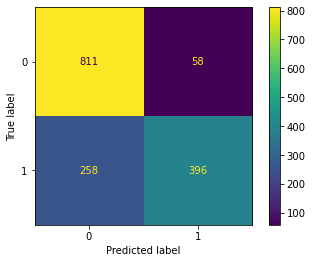

In [43]:
vec = CountVectorizer()
vec.fit(train["text"])
train_vec = vec.transform(train_data)

print(f"Bernoulli distribution, p = {train_labels.mean():.3f}")

model = BernoulliNB()
crossval = cross_validate(model, train_vec, train_labels, cv=5, return_estimator=True)
mean_score = crossval["test_score"].mean()
print(f"Mean accuracy on 5-fold cross validation = {mean_score:.3f}")
best_estimator = crossval["estimator"][crossval["test_score"].argmax()]
dev_vec = vec.transform(dev_data)
dev_score = best_estimator.score(dev_vec, dev_labels)
print(f"Validation accuracy = {dev_score:.3f}")

cm = plot_confusion_matrix(best_estimator, dev_vec, dev_labels)

In [44]:
# Testing the processor Toby created 

import string
import sys
import regex as re

FLAGS = re.MULTILINE | re.DOTALL


punctuation = string.punctuation.replace("#", "")
punctuation = punctuation.replace("<", "")
punctuation = punctuation.replace(">", "")


def _hashtag(text):
    """Parse hashtags in tweets.
    
    For hashtags with words in title case, splits into separate words, e.g.
        #BigFire -> <hashtag> Big Fire 
        
    For all caps hashtags converts to lowercase, e.g.
        #OMG -> <hashtag> omg
    """
    text = text.group()
    hashtag_body = text[1:]
    if hashtag_body.isupper():
        result = f" <hashtag> {hashtag_body.lower()} <allcaps> "
    else:
        result = " ".join([" <hashtag> "] + re.split(r"(?=[A-Z])", hashtag_body, flags=FLAGS))
    return result


def _allcaps(text):
    """Convert all-caps words to lowercase and add allcaps tag."""
    text = text.group()
    return text.lower() + " <allcaps> "


def tokenize(text):
    def re_sub(pattern, repl):
        return re.sub(pattern, repl, text, flags=FLAGS)

    # Remove URLS:
    text = re_sub(r"https?:\/\/\S+\b|www\.(\w+\.)+\S*", " <url> ")
    
    # Remove usernames:
    text = re_sub(r"@\w+", " <user> ")
    
    # Tag smiley faces :-) sad faces :-( etc.
    eyes, nose = r"[8:=;]", r"['`\-]?"
    text = re_sub(r"{}{}[)dD]+|[)dD]+{}{}".format(eyes, nose, nose, eyes), " <smile> ")
    text = re_sub(r"{}{}p+".format(eyes, nose), " <lolface> ")
    text = re_sub(r"{}{}\(+|\)+{}{}".format(eyes, nose, nose, eyes), " <sadface> ")
    text = re_sub(r"{}{}[\/|l*]".format(eyes, nose), " <neutralface> ")
    text = re_sub(r"<3"," <heart> ")

    # Add whitespace around /
    text = re_sub(r"/"," / ")
    
    # Tag numbers:
    text = re_sub(r"[-+]?[.\d]*[\d]+[:,.\d]*", " <number> ")
    
    # Tag hastags and separate hashtag words:
    text = re_sub(r"#\w+", _hashtag)
    
    # Remove and tag repetitions of question marks, exclamations:
    text = re_sub(r"([!?.]){2,}", r"\1 <repeat> ")
    
    # Tag elongated sequences of the same letter (3+ occurences), e.g. "AAAAAAA"
    text = re_sub(r"\b(\S*?)(.)\2{2,}\b", r"\1\2 <elong> ")
    
    # Put whitespace around punctuation, then remove:
    text = re_sub(r"([a-zA-Z<>()])([{}])".format(punctuation), r"\1 \2")
    text = re_sub(r"([{}])([a-zA-Z<>()])".format(punctuation), r"\1 \2")
    text = re.sub("[%s]" % re.escape(punctuation), "", text)

    # Tag all caps words:
    text = re_sub(r" ([A-Z]){2,} ", _allcaps)
    
    return " ".join(text.lower().split())


In [45]:
# Example with lots of weird features:
text = "#BigFire on #MountEverest #OMG, !! /where are police 'some' punctuation! 3now 44 @police"
tokenize(text)

'<hashtag> <elong> big fire on <hashtag> <elong> mount everest <hashtag> omg <allcaps> <repeat> where are police some punctuation <number> now <number> <user>'

In [54]:
from gensim.models.keyedvectors import KeyedVectors
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from spellchecker import SpellChecker
import yaml


class WordEmbeddings:
    """Class to create word embeddings from input tweets, 
    including text pre-processing."""
    
    def __init__(self, X: pd.Series, embeddings: KeyedVectors, 
                 processor = tokenize, spellcheck: bool = True, 
                 idf_filter: float = 0.05, stop_words: list = None):
        """
        """
        # Save the raw input as a list:
        self.X_raw = X.tolist()
        
        # Apply the preprocessor function:
        X = X.map(processor).tolist()
        
        # Apply the spelling corrections:
        if spellcheck:
            corrections = self.correct_spellings([])
            corrected = list()
            for tweet in X:
                corrected.append(" ".join([corrections.get(w, w) for w in tweet.split()]))
            X = corrected
        
        # Apply IDF to remove common words in corpus:
        if idf_filter is not None:
            vect = TfidfVectorizer(
                input="content", encoding="utf-8", lowercase=True, 
                analyzer="word", ngram_range=(1, 1), max_df=1.0, min_df=1
            )
            vect.fit(X)
            df = pd.DataFrame({"word": vect.get_feature_names(), "idf": vect.idf_})
            df.sort_values(by=["idf"], ascending=True, inplace=True)
            number = int(len(df) * idf_filter)
            drop_words = set(df.iloc[:number]["word"].tolist())
            filtered = list()
            for tweet in X:
                filtered.append(" ".join(list(filter(lambda w: w not in drop_words, tweet.split()))))
            X = filtered
        
        # Drop stop words:
        if stop_words is not None:
            filtered = list()
            for tweet in X:
                filtered.append(" ".join(list(filter(lambda w: w not in stop_words, tweet.split()))))
            X = filtered

        self.X = X
        
        # Store the word embeddings scheme:
        self.embeddings = embeddings
        
        # Unique vocabulary of the embedding scheme:
        self.embeddings_vocab = set(embeddings.key_to_index)
        
        # Unique vocabulary of the inputs:
        self.X_vocab = {w for words in [s.split() for s in X] for w in words}
        
        # Unknown words in the input:
        self.unknown_words = self.X_vocab - self.embeddings_vocab

        # Common vocabulary between the input and the embeddings scheme:
        self.common_vocab = self.embeddings_vocab & self.X_vocab
        self.vocab_coverage = len(self.common_vocab) / len(self.X_vocab)
        print(f"{len(self.X_vocab):} processed input words, "\
              f"{len(self.common_vocab):} found in embeddings "\
              f"({self.vocab_coverage*100:.2f}%).")

        # Lookup table from words to their embeddings:
        self.embeddings_table = pd.DataFrame(embeddings[self.common_vocab], index=self.common_vocab).sort_index()
        
        # Iterate through input tweets removing unknown words, creating average/min/max embeddings:
        embedding_mu, embedding_max, embedding_min, clean_tweets = list(), list(), list(), list()
        for i, tweet in enumerate(self.X):
            
            # Remove unknown words:
            words = tweet.split()
            known_words = [w for w in words if w in self.common_vocab]
            clean_tweets.append(" ".join(known_words))
            
            # Calculate mean of all word embeddings in tweet:
            mean_array = self.embeddings_table.loc[known_words].mean().values
            embedding_mu.append(mean_array)
            
            # Calculate min/max of all word embeddings in tweet:
            max_array = self.embeddings_table.loc[known_words].max().values
            embedding_max.append(max_array)
            min_array = self.embeddings_table.loc[known_words].min().values
            embedding_min.append(min_array)
            
        # Arrays of final X datasets in word embedding formats:
        self.embedding_mu = pd.DataFrame(np.array(embedding_mu))
        self.embedding_min = np.array(embedding_min)
        self.embedding_max = np.array(embedding_max)
        self.embedding_minmax = pd.DataFrame(np.concatenate([self.embedding_min, self.embedding_max], axis=1))
        
    @property
    def embedding_chars(self):
        """Unique characters in the word embeddings."""
        return "".join(sorted(set([c for w in self.embeddings.index_to_key for c in w])))
    
    @staticmethod
    def correct_spellings(words: list):
        """Use pyspellchecker to save a dictionary of unknown words
        to corrected spellings, or just load presaved corrections. 
        See:
            https://github.com/barrust/pyspellchecker
        """
        fp = os.path.join(os.getcwd(), "spelling_corrections.yaml")
        if not os.path.exists(fp):
            corrections = dict()
            with open(fp, "w") as stream:
                yaml.safe_dump(corrections, stream)
        else:
            with open(fp, "r") as stream:
                corrections = yaml.safe_load(stream)
            if corrections is None:
                corrections = dict()
        to_correct = [w for w in words if w not in corrections]
        if to_correct:
            spell = SpellChecker()
            new = {w: spell.correction(w) for w in to_correct}
            corrections = {**corrections, **new}
            with open(fp, "w") as stream:
                yaml.safe_dump(corrections, stream)
            print(f"Saved {len(new):} spelling corrections to file.")
        return corrections


In [55]:
from gensim import downloader


# Load the pretrained word embeddings (this takes a while):
glove_twitter = downloader.load("glove-twitter-200")
info = downloader.info()
print(info["models"]["glove-twitter-200"]["description"])

[=============-------------------------------------] 26.7% 202.6/758.5MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[=================================-----------------] 67.0% 508.0/758.5MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[================================================--] 96.2% 729.5/758.5MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[==================================================] 100.0% 758.5/758.5MB downloaded
Pre-trained vectors based on 2B tweets, 27B tokens, 1.2M vocab, uncased (https://nlp.stanford.edu/projects/glove/).


In [56]:
# Use the WordEmbeddings class to apply embeddings to the training & validation data:
# train_we = WordEmbeddings(train["text"], glove_twitter, idf_filter=0.05)
# validation_we = WordEmbeddings(validation["text"], glove_twitter, idf_filter=0.05)
train_we = WordEmbeddings(train["text"], glove_twitter, idf_filter=None)
validation_we = WordEmbeddings(validation["text"], glove_twitter, idf_filter=None)




12145 processed input words, 11404 found in embeddings (93.90%).
5507 processed input words, 5141 found in embeddings (93.35%).


Mean accuracy on 5-fold cross validation = 0.740
Validation accuracy = 0.737


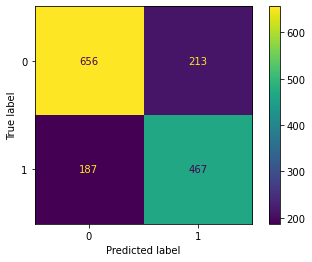

In [128]:
from sklearn import metrics

train_vec = train_we.embedding_mu

model = BernoulliNB(alpha=0.75)
crossval = cross_validate(model, train_vec, train_labels, cv=5, return_estimator=True)
mean_score = crossval["test_score"].mean()
print(f"Mean accuracy on 5-fold cross validation = {mean_score:.3f}")
best_estimator = crossval["estimator"][crossval["test_score"].argmax()]

dev_vec = validation_we.embedding_mu
dev_score = best_estimator.score(dev_vec, dev_labels)
print(f"Validation accuracy = {dev_score:.3f}")

cm = plot_confusion_matrix(best_estimator, dev_vec, dev_labels)

Mean accuracy on 5-fold cross validation = 0.801
Validation accuracy = 0.799


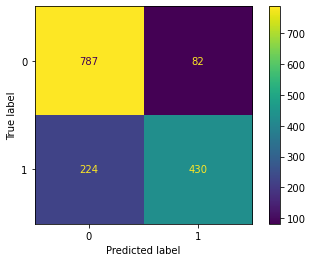

In [129]:
vec = CountVectorizer(preprocessor=tokenize)
vec.fit(train_data)
train_vec = vec.transform(train_data)

model = BernoulliNB(alpha=0.75)
crossval = cross_validate(model, train_vec, train_labels, cv=5, return_estimator=True)
mean_score = crossval["test_score"].mean()
print(f"Mean accuracy on 5-fold cross validation = {mean_score:.3f}")
best_estimator = crossval["estimator"][crossval["test_score"].argmax()]
dev_vec = vec.transform(dev_data)
dev_score = best_estimator.score(dev_vec, dev_labels)
print(f"Validation accuracy = {dev_score:.3f}")

cm = plot_confusion_matrix(best_estimator, dev_vec, dev_labels)

In [118]:
# Testing the processor Ruth created

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
nltk.download('punkt')
nltk.download('wordnet')
stemmer = PorterStemmer()
lemmer = WordNetLemmatizer()

def stem_sentence(text):
    token_words=word_tokenize(text)
    stem_sentence=[]
    for word in token_words:
        stem_sentence.append(stemmer.stem(word))
        stem_sentence.append(" ")
    return "".join(stem_sentence)

def lem_sentence(text):
    token_words=word_tokenize(text)
    stem_sentence=[]
    for word in token_words:
        stem_sentence.append(lemmer.lemmatize(word, pos='n'))
        stem_sentence.append(" ")
    return "".join(stem_sentence)

def clean_text(text):
    text = text.lower()
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text)
    text = re.sub(r'http?:\/\/.*[\r\n]*', '', text)
    text = re.sub(r"(?:\@)\w+", ' ', text)
    text = re.sub(r'[:"#$%&\*+,-/:;<=>@\\^_`{|}~?!]+',' ',text)
    text = re.sub(r"[']+",'',text)
    
    text=text.replace(r'&amp;?',r'and')
    text=text.replace(r'&lt;',r'<')
    text=text.replace(r'&gt;',r'>')
    
    text=text.encode("ascii",errors="ignore").decode()

    return text

def clean_and_lem(text):
    return lem_sentence(clean_text(text))

def clean_and_stem(text):
    return stem_sentence(clean_text(text))

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/ruthashford/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/ruthashford/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Bernoulli distribution, p = 0.430
Mean accuracy on 5-fold cross validation = 0.802
Validation accuracy = 0.807


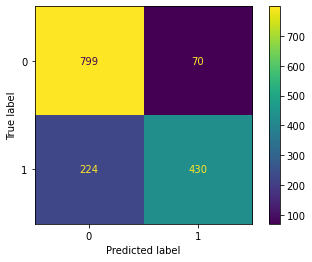

In [120]:
vec = CountVectorizer(preprocessor=clean_and_lem)
vec.fit(train_data)
train_vec = vec.transform(train_data)

model = BernoulliNB(alpha=0.75)
crossval = cross_validate(model, train_vec, train_labels, cv=5, return_estimator=True)
mean_score = crossval["test_score"].mean()
print(f"Mean accuracy on 5-fold cross validation = {mean_score:.3f}")
best_estimator = crossval["estimator"][crossval["test_score"].argmax()]
dev_vec = vec.transform(dev_data)
dev_score = best_estimator.score(dev_vec, dev_labels)
print(f"Validation accuracy = {dev_score:.3f}")

cm = plot_confusion_matrix(best_estimator, dev_vec, dev_labels)


Mean accuracy on 5-fold cross validation = 0.803
Validation accuracy = 0.808


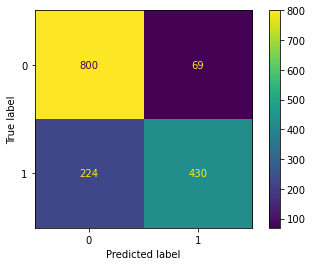

In [130]:
vec = TfidfVectorizer(preprocessor=clean_and_lem, encoding='utf-8',
                       ngram_range=(1,1),
                       max_features=11000, 
                       norm='l2'
                    )
vec.fit(train_data)
train_vec = vec.transform(train_data)

model = BernoulliNB(alpha=0.75)
crossval = cross_validate(model, train_vec, train_labels, cv=5, return_estimator=True)
mean_score = crossval["test_score"].mean()
print(f"Mean accuracy on 5-fold cross validation = {mean_score:.3f}")
best_estimator = crossval["estimator"][crossval["test_score"].argmax()]
dev_vec = vec.transform(dev_data)
dev_score = best_estimator.score(dev_vec, dev_labels)
print(f"Validation accuracy = {dev_score:.3f}")

cm = plot_confusion_matrix(best_estimator, dev_vec, dev_labels)
?best_estimator